In [1]:
import os
import json
import pickle
from zipfile import ZipFile
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers,models
from keras.layers import BatchNormalization,Dropout


In [21]:
base_dir = '/Users/arinpramanick/Desktop/SIH-Project/Cropped frames/Train_images'

In [22]:
img_size = 224
batch_size = 32
data_gen = ImageDataGenerator(
    rescale = 1./255,  #rescale the data to 0-1 range
    validation_split = 0.2 #20% data to be used for validation
)

In [23]:
train_ds = data_gen.flow_from_directory(
    base_dir,
    target_size = (img_size,img_size),  #all images are made to be of same size
    batch_size = batch_size,
    subset = 'training',
    class_mode = 'categorical'
)


Found 572 images belonging to 7 classes.


In [24]:
validation_ds = data_gen.flow_from_directory(
    base_dir,
    target_size = (img_size,img_size),
    batch_size = batch_size,
    subset = 'validation',
    class_mode = 'categorical'
)

Found 142 images belonging to 7 classes.


In [66]:
model = models.Sequential()

model.add(layers.Conv2D(32,(3,3),padding = 'valid',activation = 'relu' , input_shape = (img_size , img_size , 3)))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(64,(3,3),padding  = 'valid' , activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(128,(3,3), padding = 'valid' , activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Flatten()) #Converting to 1d vectors by Flatten() function

model.add(layers.Dense(128,activation = 'relu'))
model.add(layers.Dense(64,activation = 'relu'))

model.add(layers.Dense(train_ds.num_classes,activation = 'softmax')) #train_generator.num_classes always contains the number of classes


In [67]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,177,671 (42.64 MB)

 Trainable params: 11,177,671 (42.64 MB)

 Non-trainable params: 0 (0.00 B)

In [69]:
model.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [70]:
history = model.fit(
    train_ds,
    steps_per_epoch = train_ds.samples // batch_size, #Number of steps per epoch
    epochs = 3, #Number of epochs
    validation_data = validation_ds,
    validation_steps = validation_ds.samples // batch_size
)

Epoch 1/3
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 526ms/step - accuracy: 0.5823 - loss: 1.3613 - val_accuracy: 1.0000 - val_loss: 0.0033
Epoch 2/3
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 1.0000 - loss: 0.0018 - val_accuracy: 1.0000 - val_loss: 0.0078
Epoch 3/3
17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 501ms/step - accuracy: 1.0000 - loss: 7.8974e-04 - val_accuracy: 1.0000 - val_loss: 2.4717e-06


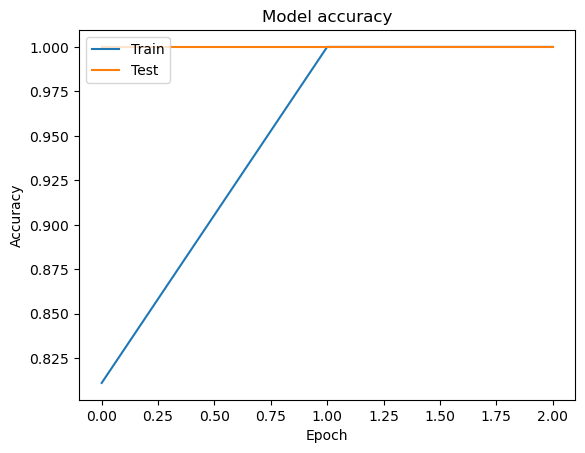

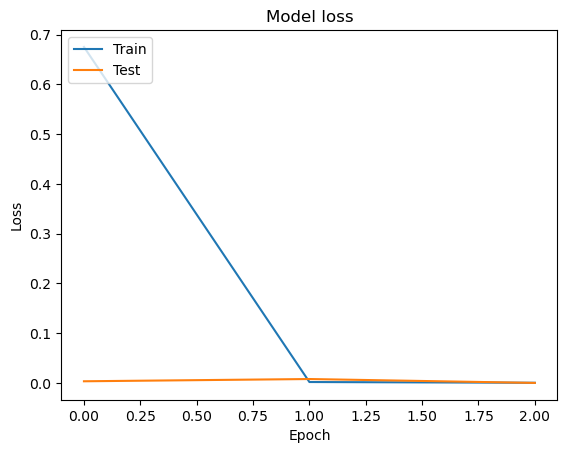

In [71]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [89]:
def load_and_preprocess_image(image_path, target_size=(224, 224)):
    # Load the image
    img = Image.open(image_path)
    # Resize the image
    img = img.resize(target_size)
    # Convert the image to a numpy array
    img_array = np.array(img)
    # Add batch dimension
    img_array = np.expand_dims(img_array, axis=0)
    # Scale the image values to [0, 1]
    img_array = img_array.astype('float32') / 255.
    return img_array

# Function to Predict the Class of an Image
def predict_image_class(model, image_path, class_indices):
    preprocessed_img = load_and_preprocess_image(image_path)
    predictions = model.predict(preprocessed_img)
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    predicted_class_name = class_indices[predicted_class_index]
    return predicted_class_name

In [90]:
class_indices = {v : k for k , v in train_ds.class_indices.items()}

In [91]:
class_indices

{0: 'D', 1: 'E', 2: 'H', 3: 'L', 4: 'O', 5: 'R', 6: 'W'}

In [92]:
json.dump(class_indices , open('class_indices_letter.json' , 'w'))

In [93]:
# image_path = '/Users/arinpramanick/Documents/Test.jpg'
image_path = '/Users/arinpramanick/Desktop/SIH-Project/Cropped frames/Train_images/E/Image_1725473532.974512.jpg'
image_path1 = '/Users/arinpramanick/Desktop/SIH-Project/Cropped frames/Train_images/W/Image_1725474781.531431.jpg'
predicted_class_name = predict_image_class(model, image_path, class_indices)
predicted_class_name1 = predict_image_class(model, image_path1, class_indices)

# Output the result
print("Predicted Class Name:", predicted_class_name)
print("Predicted Class Name:", predicted_class_name1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicted Class Name: E
Predicted Class Name: W


In [94]:
model.save('ISL_Predict.h5')